In [2]:
import numpy as np


class Node:
    def __init__(self, inputs=[]):
        self.inputs = inputs
        self.outputs = []

        for n in self.inputs:
            n.outputs.append(self)
            # set 'self' node as inbound_nodes's outbound_nodes

        self.value = None

        self.gradients = {}
        # keys are the inputs to this node, and their
        # values are the partials of this node with 
        # respect to that input.
        # \partial{node}{input_i}
        

    def forward(self):
        '''
        Forward propagation. 
        Compute the output value vased on 'inbound_nodes' and store the 
        result in self.value
        '''

        raise NotImplemented
    

    def backward(self):

        raise NotImplemented
        
class Input(Node):
    def __init__(self):
        '''
        An Input node has no inbound nodes.
        So no need to pass anything to the Node instantiator.
        '''
        Node.__init__(self)

    def forward(self, value=None):
        '''
        Only input node is the node where the value may be passed
        as an argument to forward().
        All other node implementations should get the value of the 
        previous node from self.inbound_nodes
        
        Example: 
        val0: self.inbound_nodes[0].value
        '''
        if value is not None:
            self.value = value
            ## It's is input node, when need to forward, this node initiate self's value.

        # Input subclass just holds a value, such as a data feature or a model parameter(weight/bias)
        
    def backward(self):
        self.gradients = {self:0}
        for n in self.outputs:
            grad_cost = n.gradients[self]
            self.gradients[self] = grad_cost * 1     #反向传播的梯度
            
        
        # input N --> N1, N2
        # \partial L / \partial N 
        # ==> \partial L / \partial N1 * \ partial N1 / \partial N


class Add(Node):
    def __init__(self, *nodes):
        Node.__init__(self, nodes)


    def forward(self):
        self.value = sum(map(lambda n: n.value, self.inputs))
        ## when execute forward, this node caculate value as defined.

class Linear(Node):
    def __init__(self, nodes, weights, bias):
        Node.__init__(self, [nodes, weights, bias])

    def forward(self):
        inputs = self.inputs[0].value
        weights = self.inputs[1].value
        bias = self.inputs[2].value

        self.value = np.dot(inputs, weights) + bias  # wx+b，  dot()矩阵相乘
        
    def backward(self):   #算反向传播的梯度

        # initial a partial for each of the inbound_nodes.
        self.gradients = {n: np.zeros_like(n.value) for n in self.inputs}

        for n in self.outputs:
            # Get the partial of the cost w.r.t this node.
            grad_cost = n.gradients[self]   # output对前一个节点Z求导

            self.gradients[self.inputs[0]] = np.dot(grad_cost, self.inputs[1].value.T)   #z对x求导
            self.gradients[self.inputs[1]] = np.dot(self.inputs[0].value.T, grad_cost)  #z对w求导
            self.gradients[self.inputs[2]] = np.sum(grad_cost, axis=0, keepdims=False)  #z对b求导

        # WX + B / W ==> X
        # WX + B / X ==> W

class Sigmoid(Node):
    def __init__(self, node):
        Node.__init__(self, [node])


    def _sigmoid(self, x):
        return 1./(1 + np.exp(-1 * x))

    def forward(self):
        self.x = self.inputs[0].value
        self.value = self._sigmoid(self.x)

    def backward(self):
        self.partial = self._sigmoid(self.x) * (1 - self._sigmoid(self.x))
        
        # y = 1 / (1 + e^-x)
        # y' = 1 / (1 + e^-x) (1 - 1 / (1 + e^-x))
        
        self.gradients = {n: np.zeros_like(n.value) for n in self.inputs}  #np.zeros_like(n.value)返回一个和n.value数组相同形状和类型的全0数组

        for n in self.outputs:
            grad_cost = n.gradients[self]  # Get the partial of the cost with respect to this node.

            self.gradients[self.inputs[0]] = grad_cost * self.partial
            # use * to keep all the dimension same!.



class MSE(Node):
    def __init__(self, y, a):
        Node.__init__(self, [y, a])


    def forward(self):
        y = self.inputs[0].value.reshape(-1, 1)
        a = self.inputs[1].value.reshape(-1, 1)
        assert(y.shape == a.shape)

        self.m = self.inputs[0].value.shape[0]
        self.diff = y - a

        self.value = np.mean(self.diff**2)


    def backward(self):
        self.gradients[self.inputs[0]] = (2 / self.m) * self.diff
        self.gradients[self.inputs[1]] = (-2 / self.m) * self.diff


def forward_and_backward(outputnode, graph):   # graph一个拓扑排序的图
    # execute all the forward method of sorted_nodes.

    ## In practice, it's common to feed in mutiple data example in each forward pass rather than just 1. Because the examples can be processed in parallel. The number of examples is called batch size.
    for n in graph:
        n.forward()
        ## each node execute forward, get self.value based on the topological sort result.

    for n in  graph[::-1]:  # [::-1] 从最后一个元素到第一个元素复制一遍，反省遍历一遍
        n.backward()

    #return outputnode.value

###   v -->  a -->  C
##    b --> C
##    b --> v -- a --> C
##    v --> v ---> a -- > C

def topological_sort(feed_dict):  #拓扑排序
    """
    Sort generic nodes in topological order using Kahn's Algorithm.
    `feed_dict`: A dictionary where the key is a `Input` node and the value is the respective value feed to that node.
    Returns a list of sorted nodes.
    """

    input_nodes = [n for n in feed_dict.keys()]

    G = {}
    nodes = [n for n in input_nodes]
    while len(nodes) > 0:
        n = nodes.pop(0)
        if n not in G:
            G[n] = {'in': set(), 'out': set()}
        for m in n.outputs:
            if m not in G:
                G[m] = {'in': set(), 'out': set()}
            G[n]['out'].add(m)
            G[m]['in'].add(n)
            nodes.append(m)       # 计算入度出度

    L = []
    S = set(input_nodes)
    while len(S) > 0:
        n = S.pop()

        if isinstance(n, Input):
            n.value = feed_dict[n]
            ## if n is Input Node, set n'value as 
            ## feed_dict[n]
            ## else, n's value is caculate as its
            ## inbounds

        L.append(n)
        for m in n.outputs:
            G[n]['out'].remove(m)
            G[m]['in'].remove(n)
            # if no other incoming edges add to S
            if len(G[m]['in']) == 0:
                S.add(m)            #根据入度进行排序操作
    return L   #得到排序好的列表


def sgd_update(trainables, learning_rate=1e-2):  # trainables包含所有可训练的点
    # there are so many other update / optimization methods
    # such as Adam, Mom, 
    for t in trainables:
        t.value += -1 * learning_rate * t.gradients[t]  #梯度下降算法

In [3]:
from sklearn.datasets import load_boston

In [4]:
data = load_boston()

In [5]:
losses = []

In [6]:
"""
Check out the new network architecture and dataset!
Notice that the weights and biases are
generated randomly.
No need to change anything, but feel free to tweak
to test your network, play around with the epochs, batch size, etc!
"""

import numpy as np
from sklearn.datasets import load_boston
from sklearn.utils import shuffle, resample
#from miniflow import *

# Load data
data = load_boston()
X_ = data['data']
y_ = data['target']

# Normalize data   归一化
X_ = (X_ - np.mean(X_, axis=0)) / np.std(X_, axis=0)   # np.std() 计算标准差

n_features = X_.shape[1]  #.shape查看矩阵或者数组的维数
n_hidden = 10
W1_ = np.random.randn(n_features, n_hidden)
b1_ = np.zeros(n_hidden)
W2_ = np.random.randn(n_hidden, 1)
b2_ = np.zeros(1)

# Neural network
X, y = Input(), Input()
W1, b1 = Input(), Input()
W2, b2 = Input(), Input()

l1 = Linear(X, W1, b1)
s1 = Sigmoid(l1)
l2 = Linear(s1, W2, b2)
cost = MSE(y, l2)

feed_dict = {
    X: X_,
    y: y_,
    W1: W1_,
    b1: b1_,
    W2: W2_,
    b2: b2_
}

epochs = 5000
# Total number of examples
m = X_.shape[0]
batch_size = 16
steps_per_epoch = m // batch_size

graph = topological_sort(feed_dict)
trainables = [W1, b1, W2, b2]

print("Total number of examples = {}".format(m))

# Step 4
for i in range(epochs):
    loss = 0
    for j in range(steps_per_epoch):
        # Step 1
        # Randomly sample a batch of examples
        X_batch, y_batch = resample(X_, y_, n_samples=batch_size)

        # Reset value of X and y Inputs
        X.value = X_batch
        y.value = y_batch

        # Step 2
        _ = None
        forward_and_backward(_, graph) # set output node not important.

        # Step 3
        rate = 1e-2
    
        sgd_update(trainables, rate)

        loss += graph[-1].value
    
    if i % 100 == 0: 
        print("Epoch: {}, Loss: {:.3f}".format(i+1, loss/steps_per_epoch))
        losses.append(loss)

Total number of examples = 506
Epoch: 1, Loss: 159.429
Epoch: 101, Loss: 9.054
Epoch: 201, Loss: 8.673
Epoch: 301, Loss: 5.494
Epoch: 401, Loss: 5.804
Epoch: 501, Loss: 5.641
Epoch: 601, Loss: 5.332
Epoch: 701, Loss: 5.957
Epoch: 801, Loss: 5.435
Epoch: 901, Loss: 5.352
Epoch: 1001, Loss: 4.734
Epoch: 1101, Loss: 5.253
Epoch: 1201, Loss: 4.526
Epoch: 1301, Loss: 4.461
Epoch: 1401, Loss: 4.688
Epoch: 1501, Loss: 5.038
Epoch: 1601, Loss: 3.507
Epoch: 1701, Loss: 5.152
Epoch: 1801, Loss: 4.742
Epoch: 1901, Loss: 4.779
Epoch: 2001, Loss: 4.895
Epoch: 2101, Loss: 4.627
Epoch: 2201, Loss: 4.073
Epoch: 2301, Loss: 5.065
Epoch: 2401, Loss: 3.838
Epoch: 2501, Loss: 4.442
Epoch: 2601, Loss: 4.157
Epoch: 2701, Loss: 4.082
Epoch: 2801, Loss: 3.863
Epoch: 2901, Loss: 4.325
Epoch: 3001, Loss: 4.124
Epoch: 3101, Loss: 3.974
Epoch: 3201, Loss: 4.564
Epoch: 3301, Loss: 4.160
Epoch: 3401, Loss: 3.921
Epoch: 3501, Loss: 4.132
Epoch: 3601, Loss: 3.843
Epoch: 3701, Loss: 4.511
Epoch: 3801, Loss: 3.849
Epoc

In [7]:
import matplotlib.pyplot as plt

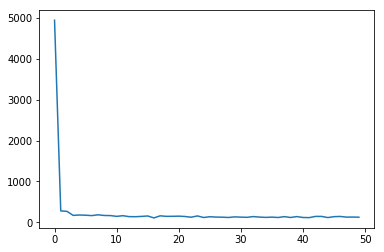

In [8]:
plt.plot(range(len(losses)), losses)

In [9]:
W2.value

array([[ 6.54213043],
       [ 6.33250599],
       [ 6.68481071],
       [13.364799  ],
       [ 7.10020494],
       [ 9.99124601],
       [11.22253478],
       [10.15154651],
       [ 5.09393024],
       [ 6.23000114]])

In [10]:
X_ = data['data']

In [29]:
X_.shape #[0]

(506, 13)

In [12]:
#!pip install keras

In [13]:
#!pip install tensorflow

In [14]:
import keras

Using TensorFlow backend.


In [15]:
X_[0]

array([6.320e-03, 1.800e+01, 2.310e+00, 0.000e+00, 5.380e-01, 6.575e+00,
       6.520e+01, 4.090e+00, 1.000e+00, 2.960e+02, 1.530e+01, 3.969e+02,
       4.980e+00])

In [16]:
from keras.layers import Dense
from keras.models import Sequential

model = Sequential()

model.add(Dense(units=64, activation='sigmoid', input_dim=13))
model.add(Dense(units=30, activation='sigmoid', input_dim=64))
model.add(Dense(units=1))

model.compile(loss='mse',
              optimizer='sgd',
              metrics=['mse'])

In [17]:
model.fit(X_, y_, epochs=5000, batch_size=32)

Epoch 1/5000
506/506 [==============================] - 1s 3ms/step - loss: 152.2005 - mse: 152.2004
Epoch 2/5000
506/506 [==============================] - 0s 69us/step - loss: 79.3608 - mse: 79.3608
Epoch 3/5000
506/506 [==============================] - 0s 67us/step - loss: 78.0875 - mse: 78.0875
Epoch 4/5000
506/506 [==============================] - 0s 73us/step - loss: 84.6195 - mse: 84.6195
Epoch 5/5000
506/506 [==============================] - 0s 75us/step - loss: 84.9842 - mse: 84.9842
Epoch 6/5000
506/506 [==============================] - 0s 77us/step - loss: 84.1148 - mse: 84.1148
Epoch 7/5000
506/506 [==============================] - 0s 85us/step - loss: 80.9176 - mse: 80.9177
Epoch 8/5000
506/506 [==============================] - 0s 89us/step - loss: 82.7505 - mse: 82.7505
Epoch 9/5000
506/506 [==============================] - 0s 91us/step - loss: 81.1856 - mse: 81.1856
Epoch 10/5000
506/506 [==============================] - 0s 229us/step - loss: 81.1584 - mse: 81.15

506/506 [==============================] - 0s 77us/step - loss: 78.6286 - mse: 78.6286
Epoch 83/5000
506/506 [==============================] - 0s 85us/step - loss: 78.7327 - mse: 78.7327
Epoch 84/5000
506/506 [==============================] - 0s 77us/step - loss: 78.3460 - mse: 78.3460
Epoch 85/5000
506/506 [==============================] - 0s 103us/step - loss: 78.7922 - mse: 78.7922
Epoch 86/5000
506/506 [==============================] - 0s 71us/step - loss: 77.6797 - mse: 77.6797
Epoch 87/5000
506/506 [==============================] - ETA: 0s - loss: 87.8706 - mse: 87.870 - 0s 63us/step - loss: 79.4158 - mse: 79.4158
Epoch 88/5000
506/506 [==============================] - 0s 67us/step - loss: 78.9956 - mse: 78.9956
Epoch 89/5000
506/506 [==============================] - 0s 63us/step - loss: 78.8268 - mse: 78.8268
Epoch 90/5000
506/506 [==============================] - 0s 71us/step - loss: 79.8261 - mse: 79.8261
Epoch 91/5000
506/506 [==============================] - 0s 73us

506/506 [==============================] - 0s 67us/step - loss: 77.7077 - mse: 77.7077
Epoch 163/5000
506/506 [==============================] - 0s 59us/step - loss: 77.6916 - mse: 77.6916
Epoch 164/5000
506/506 [==============================] - 0s 63us/step - loss: 77.9627 - mse: 77.9627
Epoch 165/5000
506/506 [==============================] - 0s 57us/step - loss: 77.9166 - mse: 77.9166
Epoch 166/5000
506/506 [==============================] - 0s 75us/step - loss: 77.9240 - mse: 77.9240
Epoch 167/5000
506/506 [==============================] - 0s 69us/step - loss: 78.2718 - mse: 78.2718
Epoch 168/5000
506/506 [==============================] - 0s 71us/step - loss: 78.5069 - mse: 78.5069
Epoch 169/5000
506/506 [==============================] - 0s 65us/step - loss: 77.8297 - mse: 77.8297
Epoch 170/5000
506/506 [==============================] - 0s 77us/step - loss: 78.2140 - mse: 78.2140
Epoch 171/5000
506/506 [==============================] - 0s 65us/step - loss: 77.2853 - mse: 77.

506/506 [==============================] - 0s 73us/step - loss: 77.8275 - mse: 77.8275
Epoch 243/5000
506/506 [==============================] - 0s 77us/step - loss: 77.4209 - mse: 77.4209
Epoch 244/5000
506/506 [==============================] - 0s 69us/step - loss: 77.7951 - mse: 77.7951
Epoch 245/5000
506/506 [==============================] - 0s 67us/step - loss: 76.8628 - mse: 76.8627
Epoch 246/5000
506/506 [==============================] - 0s 63us/step - loss: 77.5539 - mse: 77.5539
Epoch 247/5000
506/506 [==============================] - 0s 63us/step - loss: 77.9032 - mse: 77.9032
Epoch 248/5000
506/506 [==============================] - 0s 69us/step - loss: 77.5296 - mse: 77.5296
Epoch 249/5000
506/506 [==============================] - 0s 69us/step - loss: 78.6586 - mse: 78.6586
Epoch 250/5000
506/506 [==============================] - 0s 69us/step - loss: 78.5488 - mse: 78.5488
Epoch 251/5000
506/506 [==============================] - 0s 51us/step - loss: 77.4897 - mse: 77.

506/506 [==============================] - 0s 67us/step - loss: 78.0426 - mse: 78.0426
Epoch 323/5000
506/506 [==============================] - 0s 71us/step - loss: 77.6769 - mse: 77.6769
Epoch 324/5000
506/506 [==============================] - 0s 73us/step - loss: 77.9005 - mse: 77.9005
Epoch 325/5000
506/506 [==============================] - 0s 63us/step - loss: 78.2502 - mse: 78.2502
Epoch 326/5000
506/506 [==============================] - 0s 63us/step - loss: 78.0197 - mse: 78.0197
Epoch 327/5000
506/506 [==============================] - 0s 69us/step - loss: 78.1172 - mse: 78.1172
Epoch 328/5000
506/506 [==============================] - 0s 71us/step - loss: 77.7129 - mse: 77.7129
Epoch 329/5000
506/506 [==============================] - 0s 71us/step - loss: 77.8492 - mse: 77.8492
Epoch 330/5000
506/506 [==============================] - 0s 65us/step - loss: 77.4781 - mse: 77.4781
Epoch 331/5000
506/506 [==============================] - 0s 69us/step - loss: 78.4863 - mse: 78.

Epoch 402/5000
506/506 [==============================] - 0s 69us/step - loss: 78.1993 - mse: 78.1993
Epoch 403/5000
506/506 [==============================] - 0s 71us/step - loss: 77.2544 - mse: 77.2544
Epoch 404/5000
506/506 [==============================] - 0s 81us/step - loss: 77.8888 - mse: 77.8888
Epoch 405/5000
506/506 [==============================] - 0s 75us/step - loss: 77.3908 - mse: 77.3908
Epoch 406/5000
506/506 [==============================] - 0s 83us/step - loss: 77.8896 - mse: 77.8896
Epoch 407/5000
506/506 [==============================] - 0s 97us/step - loss: 77.7944 - mse: 77.7944
Epoch 408/5000
506/506 [==============================] - 0s 79us/step - loss: 77.9442 - mse: 77.9442
Epoch 409/5000
506/506 [==============================] - 0s 87us/step - loss: 77.8160 - mse: 77.8160
Epoch 410/5000
506/506 [==============================] - 0s 59us/step - loss: 77.8734 - mse: 77.8734
Epoch 411/5000
506/506 [==============================] - 0s 61us/step - loss: 77.

506/506 [==============================] - 0s 83us/step - loss: 77.2993 - mse: 77.2993
Epoch 483/5000
506/506 [==============================] - 0s 79us/step - loss: 76.8304 - mse: 76.8304
Epoch 484/5000
506/506 [==============================] - 0s 61us/step - loss: 78.1338 - mse: 78.1338
Epoch 485/5000
506/506 [==============================] - 0s 75us/step - loss: 77.7111 - mse: 77.7111
Epoch 486/5000
506/506 [==============================] - 0s 87us/step - loss: 77.4729 - mse: 77.4729
Epoch 487/5000
506/506 [==============================] - 0s 150us/step - loss: 77.7013 - mse: 77.7013
Epoch 488/5000
506/506 [==============================] - 0s 109us/step - loss: 77.5508 - mse: 77.5508
Epoch 489/5000
506/506 [==============================] - 0s 103us/step - loss: 78.4063 - mse: 78.4063
Epoch 490/5000
506/506 [==============================] - 0s 59us/step - loss: 77.5418 - mse: 77.5419
Epoch 491/5000
506/506 [==============================] - 0s 57us/step - loss: 77.7632 - mse: 

506/506 [==============================] - 0s 63us/step - loss: 78.3753 - mse: 78.3753
Epoch 563/5000
506/506 [==============================] - 0s 65us/step - loss: 77.6923 - mse: 77.6923
Epoch 564/5000
506/506 [==============================] - 0s 61us/step - loss: 77.6564 - mse: 77.6564
Epoch 565/5000
506/506 [==============================] - 0s 65us/step - loss: 78.3779 - mse: 78.3779
Epoch 566/5000
506/506 [==============================] - 0s 61us/step - loss: 77.8921 - mse: 77.8921
Epoch 567/5000
506/506 [==============================] - 0s 57us/step - loss: 78.0468 - mse: 78.0468
Epoch 568/5000
506/506 [==============================] - 0s 59us/step - loss: 77.8865 - mse: 77.8865
Epoch 569/5000
506/506 [==============================] - 0s 59us/step - loss: 77.8126 - mse: 77.8126
Epoch 570/5000
506/506 [==============================] - 0s 55us/step - loss: 77.7349 - mse: 77.7349
Epoch 571/5000
506/506 [==============================] - 0s 61us/step - loss: 77.8101 - mse: 77.

506/506 [==============================] - 0s 63us/step - loss: 77.7775 - mse: 77.7775
Epoch 642/5000
506/506 [==============================] - 0s 61us/step - loss: 78.1433 - mse: 78.1433
Epoch 643/5000
506/506 [==============================] - 0s 63us/step - loss: 78.0236 - mse: 78.0236
Epoch 644/5000
506/506 [==============================] - 0s 55us/step - loss: 78.0163 - mse: 78.0163
Epoch 645/5000
506/506 [==============================] - 0s 57us/step - loss: 78.6350 - mse: 78.6350
Epoch 646/5000
506/506 [==============================] - 0s 57us/step - loss: 78.2367 - mse: 78.2367
Epoch 647/5000
506/506 [==============================] - 0s 59us/step - loss: 77.2006 - mse: 77.2006
Epoch 648/5000
506/506 [==============================] - 0s 61us/step - loss: 77.4999 - mse: 77.4999
Epoch 649/5000
506/506 [==============================] - 0s 65us/step - loss: 77.9868 - mse: 77.9868
Epoch 650/5000
506/506 [==============================] - 0s 57us/step - loss: 77.7850 - mse: 77.

506/506 [==============================] - 0s 63us/step - loss: 77.6781 - mse: 77.6781
Epoch 722/5000
506/506 [==============================] - 0s 61us/step - loss: 77.7939 - mse: 77.7939
Epoch 723/5000
506/506 [==============================] - 0s 61us/step - loss: 76.6013 - mse: 76.6013
Epoch 724/5000
506/506 [==============================] - 0s 59us/step - loss: 77.4978 - mse: 77.4978
Epoch 725/5000
506/506 [==============================] - 0s 61us/step - loss: 78.1150 - mse: 78.1150
Epoch 726/5000
506/506 [==============================] - 0s 59us/step - loss: 77.6796 - mse: 77.6796
Epoch 727/5000
506/506 [==============================] - 0s 57us/step - loss: 77.6517 - mse: 77.6517
Epoch 728/5000
506/506 [==============================] - 0s 57us/step - loss: 77.4290 - mse: 77.4290
Epoch 729/5000
506/506 [==============================] - 0s 63us/step - loss: 78.0276 - mse: 78.0275
Epoch 730/5000
506/506 [==============================] - 0s 63us/step - loss: 78.2280 - mse: 78.

506/506 [==============================] - 0s 65us/step - loss: 77.9416 - mse: 77.9416
Epoch 802/5000
506/506 [==============================] - 0s 61us/step - loss: 78.0489 - mse: 78.0489
Epoch 803/5000
506/506 [==============================] - 0s 63us/step - loss: 77.5795 - mse: 77.5795
Epoch 804/5000
506/506 [==============================] - 0s 57us/step - loss: 77.9586 - mse: 77.9586
Epoch 805/5000
506/506 [==============================] - 0s 55us/step - loss: 77.9936 - mse: 77.9936
Epoch 806/5000
506/506 [==============================] - 0s 59us/step - loss: 77.5468 - mse: 77.5468
Epoch 807/5000
506/506 [==============================] - 0s 55us/step - loss: 78.1121 - mse: 78.1121
Epoch 808/5000
506/506 [==============================] - 0s 59us/step - loss: 77.7783 - mse: 77.7783
Epoch 809/5000
506/506 [==============================] - 0s 61us/step - loss: 78.3921 - mse: 78.3921
Epoch 810/5000
506/506 [==============================] - 0s 63us/step - loss: 77.5298 - mse: 77.

506/506 [==============================] - 0s 61us/step - loss: 77.6399 - mse: 77.6399
Epoch 882/5000
506/506 [==============================] - 0s 63us/step - loss: 78.0043 - mse: 78.0043
Epoch 883/5000
506/506 [==============================] - 0s 59us/step - loss: 77.9104 - mse: 77.9104
Epoch 884/5000
506/506 [==============================] - 0s 53us/step - loss: 77.9915 - mse: 77.9915
Epoch 885/5000
506/506 [==============================] - 0s 61us/step - loss: 77.8419 - mse: 77.8419
Epoch 886/5000
506/506 [==============================] - 0s 59us/step - loss: 78.1405 - mse: 78.1405
Epoch 887/5000
506/506 [==============================] - 0s 57us/step - loss: 77.8770 - mse: 77.8770
Epoch 888/5000
506/506 [==============================] - 0s 63us/step - loss: 77.5652 - mse: 77.5652
Epoch 889/5000
506/506 [==============================] - 0s 69us/step - loss: 77.9426 - mse: 77.9426
Epoch 890/5000
506/506 [==============================] - 0s 75us/step - loss: 77.7732 - mse: 77.

506/506 [==============================] - 0s 69us/step - loss: 77.3756 - mse: 77.3756
Epoch 961/5000
506/506 [==============================] - 0s 61us/step - loss: 77.7745 - mse: 77.7745
Epoch 962/5000
506/506 [==============================] - 0s 63us/step - loss: 77.4382 - mse: 77.4382
Epoch 963/5000
506/506 [==============================] - 0s 59us/step - loss: 77.6476 - mse: 77.6476
Epoch 964/5000
506/506 [==============================] - 0s 53us/step - loss: 77.5778 - mse: 77.5778
Epoch 965/5000
506/506 [==============================] - 0s 61us/step - loss: 77.8429 - mse: 77.8429
Epoch 966/5000
506/506 [==============================] - 0s 55us/step - loss: 77.8607 - mse: 77.8607
Epoch 967/5000
506/506 [==============================] - 0s 59us/step - loss: 77.4386 - mse: 77.4386
Epoch 968/5000
506/506 [==============================] - 0s 63us/step - loss: 78.0722 - mse: 78.0722
Epoch 969/5000
506/506 [==============================] - 0s 63us/step - loss: 78.3343 - mse: 78.

506/506 [==============================] - 0s 67us/step - loss: 78.0068 - mse: 78.0068
Epoch 1041/5000
506/506 [==============================] - 0s 69us/step - loss: 78.3893 - mse: 78.3893
Epoch 1042/5000
506/506 [==============================] - 0s 65us/step - loss: 77.8285 - mse: 77.8285
Epoch 1043/5000
506/506 [==============================] - 0s 73us/step - loss: 77.5841 - mse: 77.5841
Epoch 1044/5000
506/506 [==============================] - 0s 61us/step - loss: 77.5538 - mse: 77.5539
Epoch 1045/5000
506/506 [==============================] - 0s 69us/step - loss: 77.5549 - mse: 77.5549
Epoch 1046/5000
506/506 [==============================] - 0s 63us/step - loss: 77.5408 - mse: 77.5408
Epoch 1047/5000
506/506 [==============================] - 0s 57us/step - loss: 77.8131 - mse: 77.8131
Epoch 1048/5000
506/506 [==============================] - 0s 61us/step - loss: 77.6324 - mse: 77.6324
Epoch 1049/5000
506/506 [==============================] - 0s 59us/step - loss: 77.9564 -

506/506 [==============================] - 0s 59us/step - loss: 78.2030 - mse: 78.2030
Epoch 1120/5000
506/506 [==============================] - 0s 63us/step - loss: 77.7286 - mse: 77.7286
Epoch 1121/5000
506/506 [==============================] - 0s 55us/step - loss: 78.0191 - mse: 78.0191
Epoch 1122/5000
506/506 [==============================] - 0s 55us/step - loss: 77.7819 - mse: 77.7819
Epoch 1123/5000
506/506 [==============================] - 0s 63us/step - loss: 77.8452 - mse: 77.8452
Epoch 1124/5000
506/506 [==============================] - 0s 59us/step - loss: 78.6337 - mse: 78.6337
Epoch 1125/5000
506/506 [==============================] - 0s 67us/step - loss: 78.0057 - mse: 78.0057
Epoch 1126/5000
506/506 [==============================] - 0s 57us/step - loss: 78.3932 - mse: 78.3932
Epoch 1127/5000
506/506 [==============================] - 0s 59us/step - loss: 77.7469 - mse: 77.7469
Epoch 1128/5000
506/506 [==============================] - 0s 61us/step - loss: 78.0407 -

506/506 [==============================] - 0s 63us/step - loss: 77.6827 - mse: 77.6827
Epoch 1199/5000
506/506 [==============================] - 0s 63us/step - loss: 78.7950 - mse: 78.7950
Epoch 1200/5000
506/506 [==============================] - 0s 59us/step - loss: 77.7176 - mse: 77.7176
Epoch 1201/5000
506/506 [==============================] - 0s 59us/step - loss: 78.1819 - mse: 78.1819
Epoch 1202/5000
506/506 [==============================] - 0s 63us/step - loss: 78.3859 - mse: 78.3859
Epoch 1203/5000
506/506 [==============================] - 0s 57us/step - loss: 78.1319 - mse: 78.1319
Epoch 1204/5000
506/506 [==============================] - 0s 57us/step - loss: 77.4679 - mse: 77.4679
Epoch 1205/5000
506/506 [==============================] - 0s 59us/step - loss: 77.4663 - mse: 77.4663
Epoch 1206/5000
506/506 [==============================] - 0s 63us/step - loss: 77.5304 - mse: 77.5304
Epoch 1207/5000
506/506 [==============================] - 0s 55us/step - loss: 78.1387 -

506/506 [==============================] - 0s 69us/step - loss: 77.3002 - mse: 77.3003
Epoch 1277/5000
506/506 [==============================] - 0s 59us/step - loss: 77.6990 - mse: 77.6990
Epoch 1278/5000
506/506 [==============================] - 0s 57us/step - loss: 77.9394 - mse: 77.9394
Epoch 1279/5000
506/506 [==============================] - 0s 59us/step - loss: 77.6194 - mse: 77.6194
Epoch 1280/5000
506/506 [==============================] - 0s 57us/step - loss: 77.6869 - mse: 77.6869
Epoch 1281/5000
506/506 [==============================] - 0s 51us/step - loss: 78.1747 - mse: 78.1747
Epoch 1282/5000
506/506 [==============================] - 0s 59us/step - loss: 77.3499 - mse: 77.3499
Epoch 1283/5000
506/506 [==============================] - 0s 61us/step - loss: 77.3758 - mse: 77.3758
Epoch 1284/5000
506/506 [==============================] - 0s 57us/step - loss: 78.1071 - mse: 78.1071
Epoch 1285/5000
506/506 [==============================] - 0s 61us/step - loss: 77.4619 -

506/506 [==============================] - 0s 59us/step - loss: 77.6698 - mse: 77.6698
Epoch 1356/5000
506/506 [==============================] - 0s 55us/step - loss: 76.9491 - mse: 76.9491
Epoch 1357/5000
506/506 [==============================] - 0s 63us/step - loss: 78.2300 - mse: 78.2300
Epoch 1358/5000
506/506 [==============================] - 0s 61us/step - loss: 77.5680 - mse: 77.5680
Epoch 1359/5000
506/506 [==============================] - 0s 61us/step - loss: 77.5826 - mse: 77.5826
Epoch 1360/5000
506/506 [==============================] - 0s 57us/step - loss: 77.2876 - mse: 77.2876
Epoch 1361/5000
506/506 [==============================] - 0s 63us/step - loss: 77.6948 - mse: 77.6948
Epoch 1362/5000
506/506 [==============================] - 0s 63us/step - loss: 77.5231 - mse: 77.5231
Epoch 1363/5000
506/506 [==============================] - 0s 55us/step - loss: 77.6583 - mse: 77.6583
Epoch 1364/5000
506/506 [==============================] - 0s 57us/step - loss: 78.1002 -

506/506 [==============================] - 0s 63us/step - loss: 78.2104 - mse: 78.2104
Epoch 1435/5000
506/506 [==============================] - 0s 65us/step - loss: 77.8180 - mse: 77.8180
Epoch 1436/5000
506/506 [==============================] - 0s 67us/step - loss: 77.6237 - mse: 77.6237
Epoch 1437/5000
506/506 [==============================] - 0s 63us/step - loss: 77.7347 - mse: 77.7347
Epoch 1438/5000
506/506 [==============================] - 0s 61us/step - loss: 77.7880 - mse: 77.7880
Epoch 1439/5000
506/506 [==============================] - 0s 63us/step - loss: 77.7181 - mse: 77.7181
Epoch 1440/5000
506/506 [==============================] - 0s 61us/step - loss: 78.1284 - mse: 78.1284
Epoch 1441/5000
506/506 [==============================] - 0s 57us/step - loss: 77.4774 - mse: 77.4774
Epoch 1442/5000
506/506 [==============================] - 0s 67us/step - loss: 77.5785 - mse: 77.5785
Epoch 1443/5000
506/506 [==============================] - 0s 65us/step - loss: 77.5223 -

506/506 [==============================] - 0s 63us/step - loss: 78.3168 - mse: 78.3168
Epoch 1514/5000
506/506 [==============================] - 0s 65us/step - loss: 77.9567 - mse: 77.9567
Epoch 1515/5000
506/506 [==============================] - 0s 57us/step - loss: 77.9437 - mse: 77.9437
Epoch 1516/5000
506/506 [==============================] - 0s 63us/step - loss: 77.6174 - mse: 77.6174
Epoch 1517/5000
506/506 [==============================] - 0s 65us/step - loss: 77.8383 - mse: 77.8383
Epoch 1518/5000
506/506 [==============================] - 0s 61us/step - loss: 77.4957 - mse: 77.4957
Epoch 1519/5000
506/506 [==============================] - 0s 55us/step - loss: 78.1187 - mse: 78.1187
Epoch 1520/5000
506/506 [==============================] - 0s 65us/step - loss: 77.4772 - mse: 77.4772
Epoch 1521/5000
506/506 [==============================] - 0s 61us/step - loss: 77.8280 - mse: 77.8280
Epoch 1522/5000
506/506 [==============================] - 0s 51us/step - loss: 78.5303 -

506/506 [==============================] - 0s 65us/step - loss: 78.2686 - mse: 78.2686
Epoch 1592/5000
506/506 [==============================] - 0s 67us/step - loss: 77.4157 - mse: 77.4157
Epoch 1593/5000
506/506 [==============================] - 0s 59us/step - loss: 77.7395 - mse: 77.7395
Epoch 1594/5000
506/506 [==============================] - 0s 59us/step - loss: 78.0563 - mse: 78.0563
Epoch 1595/5000
506/506 [==============================] - 0s 61us/step - loss: 77.9975 - mse: 77.9975
Epoch 1596/5000
506/506 [==============================] - 0s 81us/step - loss: 77.5678 - mse: 77.5678
Epoch 1597/5000
506/506 [==============================] - 0s 77us/step - loss: 78.1317 - mse: 78.1317
Epoch 1598/5000
506/506 [==============================] - 0s 69us/step - loss: 77.7419 - mse: 77.7419
Epoch 1599/5000
506/506 [==============================] - 0s 75us/step - loss: 77.3508 - mse: 77.3509
Epoch 1600/5000
506/506 [==============================] - 0s 67us/step - loss: 77.3455 -

506/506 [==============================] - 0s 65us/step - loss: 77.1790 - mse: 77.1790
Epoch 1671/5000
506/506 [==============================] - 0s 63us/step - loss: 77.8092 - mse: 77.8092
Epoch 1672/5000
506/506 [==============================] - 0s 59us/step - loss: 77.6323 - mse: 77.6323
Epoch 1673/5000
506/506 [==============================] - 0s 59us/step - loss: 77.8550 - mse: 77.8550
Epoch 1674/5000
506/506 [==============================] - 0s 65us/step - loss: 77.7386 - mse: 77.7386
Epoch 1675/5000
506/506 [==============================] - 0s 59us/step - loss: 77.9051 - mse: 77.9051
Epoch 1676/5000
506/506 [==============================] - 0s 59us/step - loss: 77.6016 - mse: 77.6016
Epoch 1677/5000
506/506 [==============================] - 0s 63us/step - loss: 77.1717 - mse: 77.1717
Epoch 1678/5000
506/506 [==============================] - 0s 63us/step - loss: 77.6119 - mse: 77.6119
Epoch 1679/5000
506/506 [==============================] - 0s 55us/step - loss: 77.6943 -

506/506 [==============================] - 0s 67us/step - loss: 77.6063 - mse: 77.6063
Epoch 1750/5000
506/506 [==============================] - 0s 61us/step - loss: 77.7028 - mse: 77.7028
Epoch 1751/5000
506/506 [==============================] - 0s 61us/step - loss: 77.8719 - mse: 77.8718
Epoch 1752/5000
506/506 [==============================] - 0s 59us/step - loss: 77.6350 - mse: 77.6350
Epoch 1753/5000
506/506 [==============================] - 0s 63us/step - loss: 77.5444 - mse: 77.5444
Epoch 1754/5000
506/506 [==============================] - 0s 63us/step - loss: 77.5097 - mse: 77.5097
Epoch 1755/5000
506/506 [==============================] - 0s 63us/step - loss: 77.4541 - mse: 77.4541
Epoch 1756/5000
506/506 [==============================] - 0s 59us/step - loss: 77.7401 - mse: 77.7401
Epoch 1757/5000
506/506 [==============================] - 0s 65us/step - loss: 77.5729 - mse: 77.5729
Epoch 1758/5000
506/506 [==============================] - 0s 77us/step - loss: 77.6450 -

506/506 [==============================] - 0s 67us/step - loss: 77.4584 - mse: 77.4584
Epoch 1829/5000
506/506 [==============================] - 0s 69us/step - loss: 77.5727 - mse: 77.5727
Epoch 1830/5000
506/506 [==============================] - 0s 61us/step - loss: 77.8571 - mse: 77.8571
Epoch 1831/5000
506/506 [==============================] - 0s 61us/step - loss: 78.0811 - mse: 78.0811
Epoch 1832/5000
506/506 [==============================] - 0s 63us/step - loss: 77.8488 - mse: 77.8488
Epoch 1833/5000
506/506 [==============================] - 0s 55us/step - loss: 77.4681 - mse: 77.4681
Epoch 1834/5000
506/506 [==============================] - 0s 63us/step - loss: 77.6613 - mse: 77.6613
Epoch 1835/5000
506/506 [==============================] - 0s 63us/step - loss: 77.6140 - mse: 77.6140
Epoch 1836/5000
506/506 [==============================] - 0s 57us/step - loss: 77.5526 - mse: 77.5526
Epoch 1837/5000
506/506 [==============================] - 0s 61us/step - loss: 78.0429 -

506/506 [==============================] - 0s 63us/step - loss: 77.5536 - mse: 77.5536
Epoch 1908/5000
506/506 [==============================] - 0s 65us/step - loss: 77.8320 - mse: 77.8320
Epoch 1909/5000
506/506 [==============================] - 0s 59us/step - loss: 77.9134 - mse: 77.9134
Epoch 1910/5000
506/506 [==============================] - 0s 59us/step - loss: 77.8450 - mse: 77.8450
Epoch 1911/5000
506/506 [==============================] - 0s 63us/step - loss: 78.0477 - mse: 78.0477
Epoch 1912/5000
506/506 [==============================] - 0s 55us/step - loss: 77.3805 - mse: 77.3805
Epoch 1913/5000
506/506 [==============================] - 0s 61us/step - loss: 77.9592 - mse: 77.9592
Epoch 1914/5000
506/506 [==============================] - 0s 61us/step - loss: 77.5749 - mse: 77.5749
Epoch 1915/5000
506/506 [==============================] - 0s 59us/step - loss: 78.2718 - mse: 78.2718
Epoch 1916/5000
506/506 [==============================] - 0s 53us/step - loss: 77.5246 -

506/506 [==============================] - 0s 57us/step - loss: 77.6152 - mse: 77.6152
Epoch 1987/5000
506/506 [==============================] - 0s 67us/step - loss: 77.5125 - mse: 77.5125
Epoch 1988/5000
506/506 [==============================] - 0s 57us/step - loss: 77.5645 - mse: 77.5645
Epoch 1989/5000
506/506 [==============================] - 0s 61us/step - loss: 78.2069 - mse: 78.2069
Epoch 1990/5000
506/506 [==============================] - 0s 61us/step - loss: 78.1326 - mse: 78.1326
Epoch 1991/5000
506/506 [==============================] - 0s 61us/step - loss: 77.6204 - mse: 77.6204
Epoch 1992/5000
506/506 [==============================] - 0s 59us/step - loss: 77.7512 - mse: 77.7512
Epoch 1993/5000
506/506 [==============================] - 0s 57us/step - loss: 78.0346 - mse: 78.0346
Epoch 1994/5000
506/506 [==============================] - 0s 65us/step - loss: 77.8146 - mse: 77.8146
Epoch 1995/5000
506/506 [==============================] - 0s 67us/step - loss: 78.4471 -

506/506 [==============================] - 0s 61us/step - loss: 77.9142 - mse: 77.9142
Epoch 2066/5000
506/506 [==============================] - 0s 65us/step - loss: 77.9346 - mse: 77.9346
Epoch 2067/5000
506/506 [==============================] - 0s 61us/step - loss: 77.3082 - mse: 77.3082
Epoch 2068/5000
506/506 [==============================] - 0s 63us/step - loss: 77.8539 - mse: 77.8540
Epoch 2069/5000
506/506 [==============================] - 0s 61us/step - loss: 77.8774 - mse: 77.8774
Epoch 2070/5000
506/506 [==============================] - 0s 61us/step - loss: 77.9711 - mse: 77.9711
Epoch 2071/5000
506/506 [==============================] - 0s 63us/step - loss: 77.7695 - mse: 77.7695
Epoch 2072/5000
506/506 [==============================] - 0s 61us/step - loss: 77.8256 - mse: 77.8256
Epoch 2073/5000
506/506 [==============================] - 0s 63us/step - loss: 77.5999 - mse: 77.5999
Epoch 2074/5000
506/506 [==============================] - 0s 59us/step - loss: 77.4608 -

506/506 [==============================] - 0s 59us/step - loss: 77.7792 - mse: 77.7792
Epoch 2144/5000
506/506 [==============================] - 0s 63us/step - loss: 77.4266 - mse: 77.4266
Epoch 2145/5000
506/506 [==============================] - 0s 63us/step - loss: 77.9728 - mse: 77.9728
Epoch 2146/5000
506/506 [==============================] - 0s 61us/step - loss: 77.4864 - mse: 77.4864
Epoch 2147/5000
506/506 [==============================] - 0s 59us/step - loss: 77.6825 - mse: 77.6825
Epoch 2148/5000
506/506 [==============================] - 0s 63us/step - loss: 78.2515 - mse: 78.2515
Epoch 2149/5000
506/506 [==============================] - 0s 61us/step - loss: 77.5838 - mse: 77.5838
Epoch 2150/5000
506/506 [==============================] - 0s 71us/step - loss: 78.0308 - mse: 78.0308
Epoch 2151/5000
506/506 [==============================] - 0s 81us/step - loss: 77.1033 - mse: 77.1033
Epoch 2152/5000
506/506 [==============================] - 0s 77us/step - loss: 77.8257 -

506/506 [==============================] - 0s 61us/step - loss: 77.6914 - mse: 77.6914
Epoch 2223/5000
506/506 [==============================] - 0s 65us/step - loss: 77.6589 - mse: 77.6590
Epoch 2224/5000
506/506 [==============================] - 0s 57us/step - loss: 77.4152 - mse: 77.4152
Epoch 2225/5000
506/506 [==============================] - 0s 57us/step - loss: 77.5232 - mse: 77.5232
Epoch 2226/5000
506/506 [==============================] - 0s 67us/step - loss: 77.4689 - mse: 77.4689
Epoch 2227/5000
506/506 [==============================] - 0s 65us/step - loss: 77.7103 - mse: 77.7103
Epoch 2228/5000
506/506 [==============================] - 0s 55us/step - loss: 78.7185 - mse: 78.7186
Epoch 2229/5000
506/506 [==============================] - 0s 57us/step - loss: 77.6809 - mse: 77.6809
Epoch 2230/5000
506/506 [==============================] - 0s 63us/step - loss: 77.9564 - mse: 77.9564
Epoch 2231/5000
506/506 [==============================] - 0s 65us/step - loss: 77.7748 -

506/506 [==============================] - 0s 63us/step - loss: 77.8276 - mse: 77.8276
Epoch 2302/5000
506/506 [==============================] - 0s 67us/step - loss: 77.3542 - mse: 77.3542
Epoch 2303/5000
506/506 [==============================] - 0s 65us/step - loss: 77.9121 - mse: 77.9121
Epoch 2304/5000
506/506 [==============================] - 0s 61us/step - loss: 77.7064 - mse: 77.7064
Epoch 2305/5000
506/506 [==============================] - 0s 59us/step - loss: 77.6146 - mse: 77.6146
Epoch 2306/5000
506/506 [==============================] - 0s 59us/step - loss: 77.6998 - mse: 77.6998
Epoch 2307/5000
506/506 [==============================] - 0s 69us/step - loss: 77.8656 - mse: 77.8656
Epoch 2308/5000
506/506 [==============================] - 0s 61us/step - loss: 77.5751 - mse: 77.5751
Epoch 2309/5000
506/506 [==============================] - 0s 59us/step - loss: 77.7318 - mse: 77.7318
Epoch 2310/5000
506/506 [==============================] - 0s 63us/step - loss: 77.8923 -

506/506 [==============================] - 0s 59us/step - loss: 77.8670 - mse: 77.8670
Epoch 2381/5000
506/506 [==============================] - 0s 61us/step - loss: 77.6384 - mse: 77.6384
Epoch 2382/5000
506/506 [==============================] - 0s 61us/step - loss: 77.4489 - mse: 77.4489
Epoch 2383/5000
506/506 [==============================] - 0s 55us/step - loss: 78.1406 - mse: 78.1406
Epoch 2384/5000
506/506 [==============================] - 0s 67us/step - loss: 77.4929 - mse: 77.4929
Epoch 2385/5000
506/506 [==============================] - 0s 63us/step - loss: 77.5890 - mse: 77.5890
Epoch 2386/5000
506/506 [==============================] - 0s 59us/step - loss: 77.8905 - mse: 77.8905
Epoch 2387/5000
506/506 [==============================] - 0s 57us/step - loss: 78.3574 - mse: 78.3574
Epoch 2388/5000
506/506 [==============================] - 0s 61us/step - loss: 77.8415 - mse: 77.8414
Epoch 2389/5000
506/506 [==============================] - 0s 61us/step - loss: 77.5916 -

506/506 [==============================] - 0s 67us/step - loss: 78.1199 - mse: 78.1199
Epoch 2460/5000
506/506 [==============================] - 0s 67us/step - loss: 77.4895 - mse: 77.4895
Epoch 2461/5000
506/506 [==============================] - 0s 65us/step - loss: 77.7860 - mse: 77.7860
Epoch 2462/5000
506/506 [==============================] - 0s 61us/step - loss: 77.5877 - mse: 77.5877
Epoch 2463/5000
506/506 [==============================] - 0s 61us/step - loss: 78.0657 - mse: 78.0657
Epoch 2464/5000
506/506 [==============================] - 0s 59us/step - loss: 77.6143 - mse: 77.6143
Epoch 2465/5000
506/506 [==============================] - ETA: 0s - loss: 107.1509 - mse: 107.150 - 0s 53us/step - loss: 77.3334 - mse: 77.3334
Epoch 2466/5000
506/506 [==============================] - 0s 57us/step - loss: 77.6504 - mse: 77.6504
Epoch 2467/5000
506/506 [==============================] - 0s 61us/step - loss: 77.3742 - mse: 77.3742
Epoch 2468/5000
506/506 [======================

506/506 [==============================] - 0s 65us/step - loss: 77.8594 - mse: 77.8594
Epoch 2539/5000
506/506 [==============================] - 0s 67us/step - loss: 77.6350 - mse: 77.6350
Epoch 2540/5000
506/506 [==============================] - 0s 59us/step - loss: 77.8093 - mse: 77.8093
Epoch 2541/5000
506/506 [==============================] - 0s 61us/step - loss: 77.4928 - mse: 77.4928
Epoch 2542/5000
506/506 [==============================] - 0s 65us/step - loss: 77.6486 - mse: 77.6486
Epoch 2543/5000
506/506 [==============================] - 0s 71us/step - loss: 78.2430 - mse: 78.2430
Epoch 2544/5000
506/506 [==============================] - 0s 75us/step - loss: 77.5910 - mse: 77.5910
Epoch 2545/5000
506/506 [==============================] - 0s 59us/step - loss: 78.1135 - mse: 78.1135
Epoch 2546/5000
506/506 [==============================] - 0s 61us/step - loss: 77.7634 - mse: 77.7634
Epoch 2547/5000
506/506 [==============================] - 0s 63us/step - loss: 77.4785 -

506/506 [==============================] - 0s 67us/step - loss: 77.7764 - mse: 77.7765
Epoch 2618/5000
506/506 [==============================] - 0s 75us/step - loss: 77.8617 - mse: 77.8617
Epoch 2619/5000
506/506 [==============================] - 0s 55us/step - loss: 77.5937 - mse: 77.5937
Epoch 2620/5000
506/506 [==============================] - 0s 63us/step - loss: 78.4591 - mse: 78.4591
Epoch 2621/5000
506/506 [==============================] - 0s 67us/step - loss: 78.2121 - mse: 78.2121
Epoch 2622/5000
506/506 [==============================] - 0s 65us/step - loss: 77.7669 - mse: 77.7669
Epoch 2623/5000
506/506 [==============================] - 0s 63us/step - loss: 77.3090 - mse: 77.3090
Epoch 2624/5000
506/506 [==============================] - 0s 57us/step - loss: 77.7278 - mse: 77.7278
Epoch 2625/5000
506/506 [==============================] - 0s 63us/step - loss: 77.8840 - mse: 77.8840
Epoch 2626/5000
506/506 [==============================] - 0s 63us/step - loss: 77.6113 -

506/506 [==============================] - 0s 67us/step - loss: 77.3620 - mse: 77.3620
Epoch 2697/5000
506/506 [==============================] - 0s 69us/step - loss: 77.6651 - mse: 77.6651
Epoch 2698/5000
506/506 [==============================] - 0s 59us/step - loss: 77.6241 - mse: 77.6241
Epoch 2699/5000
506/506 [==============================] - 0s 59us/step - loss: 77.4180 - mse: 77.4180
Epoch 2700/5000
506/506 [==============================] - 0s 55us/step - loss: 78.0767 - mse: 78.0767
Epoch 2701/5000
506/506 [==============================] - 0s 63us/step - loss: 77.5051 - mse: 77.5051
Epoch 2702/5000
506/506 [==============================] - 0s 61us/step - loss: 77.6624 - mse: 77.6624
Epoch 2703/5000
506/506 [==============================] - 0s 71us/step - loss: 77.4205 - mse: 77.4205
Epoch 2704/5000
506/506 [==============================] - 0s 79us/step - loss: 77.6574 - mse: 77.6574
Epoch 2705/5000
506/506 [==============================] - 0s 75us/step - loss: 77.5664 -

506/506 [==============================] - 0s 67us/step - loss: 77.6714 - mse: 77.6714
Epoch 2776/5000
506/506 [==============================] - 0s 57us/step - loss: 77.6752 - mse: 77.6752
Epoch 2777/5000
506/506 [==============================] - 0s 65us/step - loss: 77.3869 - mse: 77.3869
Epoch 2778/5000
506/506 [==============================] - 0s 63us/step - loss: 77.4952 - mse: 77.4952
Epoch 2779/5000
506/506 [==============================] - 0s 63us/step - loss: 77.7435 - mse: 77.7435
Epoch 2780/5000
506/506 [==============================] - 0s 61us/step - loss: 77.6226 - mse: 77.6226
Epoch 2781/5000
506/506 [==============================] - 0s 55us/step - loss: 77.7341 - mse: 77.7341
Epoch 2782/5000
506/506 [==============================] - 0s 55us/step - loss: 77.2184 - mse: 77.2185
Epoch 2783/5000
506/506 [==============================] - 0s 55us/step - loss: 77.3833 - mse: 77.3833
Epoch 2784/5000
506/506 [==============================] - 0s 65us/step - loss: 77.2818 -

506/506 [==============================] - 0s 61us/step - loss: 77.4088 - mse: 77.4088
Epoch 2854/5000
506/506 [==============================] - 0s 69us/step - loss: 77.9317 - mse: 77.9317
Epoch 2855/5000
506/506 [==============================] - 0s 57us/step - loss: 77.5600 - mse: 77.5600
Epoch 2856/5000
506/506 [==============================] - 0s 57us/step - loss: 77.6984 - mse: 77.6984
Epoch 2857/5000
506/506 [==============================] - 0s 65us/step - loss: 77.6934 - mse: 77.6934
Epoch 2858/5000
506/506 [==============================] - 0s 59us/step - loss: 77.5197 - mse: 77.5197
Epoch 2859/5000
506/506 [==============================] - 0s 63us/step - loss: 78.0594 - mse: 78.0594
Epoch 2860/5000
506/506 [==============================] - 0s 65us/step - loss: 77.3739 - mse: 77.3739
Epoch 2861/5000
506/506 [==============================] - 0s 65us/step - loss: 77.4930 - mse: 77.4930
Epoch 2862/5000
506/506 [==============================] - 0s 63us/step - loss: 77.9211 -

506/506 [==============================] - 0s 63us/step - loss: 77.3985 - mse: 77.3985
Epoch 2933/5000
506/506 [==============================] - 0s 65us/step - loss: 77.6506 - mse: 77.6506
Epoch 2934/5000
506/506 [==============================] - 0s 61us/step - loss: 77.4000 - mse: 77.4000
Epoch 2935/5000
506/506 [==============================] - 0s 61us/step - loss: 77.6580 - mse: 77.6580
Epoch 2936/5000
506/506 [==============================] - 0s 61us/step - loss: 77.6913 - mse: 77.6913
Epoch 2937/5000
506/506 [==============================] - 0s 67us/step - loss: 77.6627 - mse: 77.6627
Epoch 2938/5000
506/506 [==============================] - 0s 61us/step - loss: 77.8449 - mse: 77.8449
Epoch 2939/5000
506/506 [==============================] - 0s 59us/step - loss: 77.3549 - mse: 77.3549
Epoch 2940/5000
506/506 [==============================] - 0s 61us/step - loss: 77.7937 - mse: 77.7937
Epoch 2941/5000
506/506 [==============================] - 0s 61us/step - loss: 77.8252 -

506/506 [==============================] - 0s 65us/step - loss: 77.6324 - mse: 77.6324
Epoch 3012/5000
506/506 [==============================] - 0s 67us/step - loss: 77.4824 - mse: 77.4824
Epoch 3013/5000
506/506 [==============================] - 0s 61us/step - loss: 77.7195 - mse: 77.7195
Epoch 3014/5000
506/506 [==============================] - 0s 57us/step - loss: 77.6969 - mse: 77.6969
Epoch 3015/5000
506/506 [==============================] - 0s 65us/step - loss: 77.7875 - mse: 77.7875
Epoch 3016/5000
506/506 [==============================] - 0s 55us/step - loss: 77.4501 - mse: 77.4501
Epoch 3017/5000
506/506 [==============================] - 0s 59us/step - loss: 77.3431 - mse: 77.3431
Epoch 3018/5000
506/506 [==============================] - 0s 63us/step - loss: 77.6901 - mse: 77.6901
Epoch 3019/5000
506/506 [==============================] - 0s 59us/step - loss: 77.8166 - mse: 77.8166
Epoch 3020/5000
506/506 [==============================] - 0s 53us/step - loss: 77.7702 -

506/506 [==============================] - 0s 61us/step - loss: 77.5483 - mse: 77.5483
Epoch 3091/5000
506/506 [==============================] - 0s 67us/step - loss: 77.3957 - mse: 77.3957
Epoch 3092/5000
506/506 [==============================] - 0s 61us/step - loss: 77.7843 - mse: 77.7843
Epoch 3093/5000
506/506 [==============================] - 0s 65us/step - loss: 77.8607 - mse: 77.8607
Epoch 3094/5000
506/506 [==============================] - 0s 69us/step - loss: 77.6317 - mse: 77.6317
Epoch 3095/5000
506/506 [==============================] - 0s 63us/step - loss: 77.5857 - mse: 77.5857
Epoch 3096/5000
506/506 [==============================] - 0s 55us/step - loss: 77.3431 - mse: 77.3431
Epoch 3097/5000
506/506 [==============================] - 0s 61us/step - loss: 78.0987 - mse: 78.0987
Epoch 3098/5000
506/506 [==============================] - 0s 63us/step - loss: 77.8635 - mse: 77.8635
Epoch 3099/5000
506/506 [==============================] - 0s 57us/step - loss: 77.7654 -

506/506 [==============================] - 0s 61us/step - loss: 77.4673 - mse: 77.4673
Epoch 3170/5000
506/506 [==============================] - 0s 63us/step - loss: 78.1994 - mse: 78.1994
Epoch 3171/5000
506/506 [==============================] - 0s 61us/step - loss: 77.6074 - mse: 77.6074
Epoch 3172/5000
506/506 [==============================] - 0s 57us/step - loss: 77.6102 - mse: 77.6102
Epoch 3173/5000
506/506 [==============================] - 0s 65us/step - loss: 77.4394 - mse: 77.4394
Epoch 3174/5000
506/506 [==============================] - 0s 59us/step - loss: 77.5770 - mse: 77.5770
Epoch 3175/5000
506/506 [==============================] - 0s 63us/step - loss: 77.6368 - mse: 77.6368
Epoch 3176/5000
506/506 [==============================] - 0s 63us/step - loss: 77.7420 - mse: 77.7420
Epoch 3177/5000
506/506 [==============================] - 0s 71us/step - loss: 77.5200 - mse: 77.5200
Epoch 3178/5000
506/506 [==============================] - 0s 63us/step - loss: 77.7974 -

506/506 [==============================] - 0s 61us/step - loss: 77.4361 - mse: 77.4361
Epoch 3249/5000
506/506 [==============================] - 0s 63us/step - loss: 77.6211 - mse: 77.6211
Epoch 3250/5000
506/506 [==============================] - 0s 53us/step - loss: 77.7989 - mse: 77.7989
Epoch 3251/5000
506/506 [==============================] - 0s 57us/step - loss: 77.6986 - mse: 77.6986
Epoch 3252/5000
506/506 [==============================] - 0s 61us/step - loss: 78.0987 - mse: 78.0987
Epoch 3253/5000
506/506 [==============================] - 0s 63us/step - loss: 77.7188 - mse: 77.7188
Epoch 3254/5000
506/506 [==============================] - 0s 61us/step - loss: 77.9666 - mse: 77.9666
Epoch 3255/5000
506/506 [==============================] - 0s 61us/step - loss: 77.7999 - mse: 77.7999
Epoch 3256/5000
506/506 [==============================] - 0s 77us/step - loss: 77.2313 - mse: 77.2313
Epoch 3257/5000
506/506 [==============================] - 0s 79us/step - loss: 77.5991 -

506/506 [==============================] - 0s 63us/step - loss: 77.8704 - mse: 77.8704
Epoch 3328/5000
506/506 [==============================] - 0s 69us/step - loss: 78.1205 - mse: 78.1205
Epoch 3329/5000
506/506 [==============================] - 0s 61us/step - loss: 77.3297 - mse: 77.3297
Epoch 3330/5000
506/506 [==============================] - 0s 59us/step - loss: 78.7128 - mse: 78.7128
Epoch 3331/5000
506/506 [==============================] - 0s 59us/step - loss: 77.6185 - mse: 77.6185
Epoch 3332/5000
506/506 [==============================] - 0s 57us/step - loss: 77.9593 - mse: 77.9593
Epoch 3333/5000
506/506 [==============================] - 0s 57us/step - loss: 77.4529 - mse: 77.4529
Epoch 3334/5000
506/506 [==============================] - 0s 67us/step - loss: 78.1521 - mse: 78.1521
Epoch 3335/5000
506/506 [==============================] - 0s 63us/step - loss: 77.3776 - mse: 77.3776
Epoch 3336/5000
506/506 [==============================] - 0s 63us/step - loss: 77.4916 -

506/506 [==============================] - 0s 61us/step - loss: 78.0233 - mse: 78.0233
Epoch 3407/5000
506/506 [==============================] - 0s 63us/step - loss: 77.4362 - mse: 77.4362
Epoch 3408/5000
506/506 [==============================] - 0s 67us/step - loss: 77.5684 - mse: 77.5684
Epoch 3409/5000
506/506 [==============================] - 0s 63us/step - loss: 77.4672 - mse: 77.4672
Epoch 3410/5000
506/506 [==============================] - 0s 59us/step - loss: 77.2459 - mse: 77.2459
Epoch 3411/5000
506/506 [==============================] - 0s 63us/step - loss: 77.6772 - mse: 77.6772
Epoch 3412/5000
506/506 [==============================] - 0s 63us/step - loss: 77.5747 - mse: 77.5747
Epoch 3413/5000
506/506 [==============================] - 0s 63us/step - loss: 77.9770 - mse: 77.9770
Epoch 3414/5000
506/506 [==============================] - 0s 55us/step - loss: 77.7801 - mse: 77.7801
Epoch 3415/5000
506/506 [==============================] - 0s 61us/step - loss: 77.6100 -

506/506 [==============================] - 0s 69us/step - loss: 77.5683 - mse: 77.5683
Epoch 3486/5000
506/506 [==============================] - 0s 61us/step - loss: 77.8110 - mse: 77.8110
Epoch 3487/5000
506/506 [==============================] - 0s 69us/step - loss: 77.5799 - mse: 77.5799
Epoch 3488/5000
506/506 [==============================] - 0s 69us/step - loss: 77.6389 - mse: 77.6389
Epoch 3489/5000
506/506 [==============================] - 0s 61us/step - loss: 78.0000 - mse: 78.0000
Epoch 3490/5000
506/506 [==============================] - 0s 59us/step - loss: 77.8812 - mse: 77.8812
Epoch 3491/5000
506/506 [==============================] - 0s 63us/step - loss: 77.6686 - mse: 77.6686
Epoch 3492/5000
506/506 [==============================] - 0s 61us/step - loss: 77.8345 - mse: 77.8345
Epoch 3493/5000
506/506 [==============================] - 0s 61us/step - loss: 77.3450 - mse: 77.3450
Epoch 3494/5000
506/506 [==============================] - 0s 57us/step - loss: 77.5939 -

506/506 [==============================] - 0s 57us/step - loss: 77.8646 - mse: 77.8646
Epoch 3564/5000
506/506 [==============================] - 0s 67us/step - loss: 77.3606 - mse: 77.3606
Epoch 3565/5000
506/506 [==============================] - 0s 59us/step - loss: 77.8930 - mse: 77.8930
Epoch 3566/5000
506/506 [==============================] - 0s 63us/step - loss: 77.6495 - mse: 77.6495
Epoch 3567/5000
506/506 [==============================] - 0s 63us/step - loss: 77.9252 - mse: 77.9252
Epoch 3568/5000
506/506 [==============================] - 0s 63us/step - loss: 77.6669 - mse: 77.6669
Epoch 3569/5000
506/506 [==============================] - 0s 59us/step - loss: 77.4439 - mse: 77.4439
Epoch 3570/5000
506/506 [==============================] - 0s 61us/step - loss: 77.6601 - mse: 77.6601
Epoch 3571/5000
506/506 [==============================] - 0s 65us/step - loss: 77.6674 - mse: 77.6674
Epoch 3572/5000
506/506 [==============================] - 0s 67us/step - loss: 77.4524 -

506/506 [==============================] - 0s 65us/step - loss: 78.0379 - mse: 78.0378
Epoch 3643/5000
506/506 [==============================] - 0s 63us/step - loss: 77.7110 - mse: 77.7110
Epoch 3644/5000
506/506 [==============================] - 0s 69us/step - loss: 77.5899 - mse: 77.5899
Epoch 3645/5000
506/506 [==============================] - 0s 71us/step - loss: 77.5503 - mse: 77.5503
Epoch 3646/5000
506/506 [==============================] - 0s 79us/step - loss: 77.4847 - mse: 77.4847
Epoch 3647/5000
506/506 [==============================] - 0s 67us/step - loss: 78.0414 - mse: 78.0414
Epoch 3648/5000
506/506 [==============================] - 0s 69us/step - loss: 77.4357 - mse: 77.4357
Epoch 3649/5000
506/506 [==============================] - 0s 77us/step - loss: 77.8523 - mse: 77.8522
Epoch 3650/5000
506/506 [==============================] - 0s 65us/step - loss: 78.0109 - mse: 78.0109
Epoch 3651/5000
506/506 [==============================] - 0s 65us/step - loss: 77.5777 -

506/506 [==============================] - 0s 65us/step - loss: 77.5467 - mse: 77.5467
Epoch 3721/5000
506/506 [==============================] - 0s 59us/step - loss: 77.4736 - mse: 77.4736
Epoch 3722/5000
506/506 [==============================] - 0s 59us/step - loss: 77.9411 - mse: 77.9411
Epoch 3723/5000
506/506 [==============================] - 0s 61us/step - loss: 77.4816 - mse: 77.4816
Epoch 3724/5000
506/506 [==============================] - 0s 95us/step - loss: 78.1165 - mse: 78.1165
Epoch 3725/5000
506/506 [==============================] - 0s 119us/step - loss: 77.6167 - mse: 77.6167
Epoch 3726/5000
506/506 [==============================] - 0s 91us/step - loss: 77.7169 - mse: 77.7169
Epoch 3727/5000
506/506 [==============================] - 0s 87us/step - loss: 77.7412 - mse: 77.7411
Epoch 3728/5000
506/506 [==============================] - 0s 77us/step - loss: 77.6801 - mse: 77.6801
Epoch 3729/5000
506/506 [==============================] - 0s 79us/step - loss: 77.2719 

506/506 [==============================] - 0s 77us/step - loss: 78.1005 - mse: 78.1005
Epoch 3799/5000
506/506 [==============================] - 0s 75us/step - loss: 77.5622 - mse: 77.5622
Epoch 3800/5000
506/506 [==============================] - 0s 81us/step - loss: 77.7035 - mse: 77.7036
Epoch 3801/5000
506/506 [==============================] - 0s 81us/step - loss: 77.5886 - mse: 77.5886
Epoch 3802/5000
506/506 [==============================] - 0s 81us/step - loss: 77.3717 - mse: 77.3717
Epoch 3803/5000
506/506 [==============================] - 0s 99us/step - loss: 77.8823 - mse: 77.8823
Epoch 3804/5000
506/506 [==============================] - 0s 93us/step - loss: 77.4029 - mse: 77.4029
Epoch 3805/5000
506/506 [==============================] - 0s 81us/step - loss: 77.5266 - mse: 77.5266
Epoch 3806/5000
506/506 [==============================] - 0s 77us/step - loss: 77.8163 - mse: 77.8163
Epoch 3807/5000
506/506 [==============================] - 0s 79us/step - loss: 77.5498 -

506/506 [==============================] - 0s 87us/step - loss: 77.4591 - mse: 77.4591
Epoch 3878/5000
506/506 [==============================] - 0s 81us/step - loss: 77.8357 - mse: 77.8357
Epoch 3879/5000
506/506 [==============================] - 0s 85us/step - loss: 77.5251 - mse: 77.5251
Epoch 3880/5000
506/506 [==============================] - 0s 75us/step - loss: 77.5081 - mse: 77.5081
Epoch 3881/5000
506/506 [==============================] - 0s 89us/step - loss: 77.8258 - mse: 77.8258
Epoch 3882/5000
506/506 [==============================] - 0s 81us/step - loss: 77.8817 - mse: 77.8816
Epoch 3883/5000
506/506 [==============================] - 0s 81us/step - loss: 77.6732 - mse: 77.6732
Epoch 3884/5000
506/506 [==============================] - 0s 77us/step - loss: 77.5087 - mse: 77.5087
Epoch 3885/5000
506/506 [==============================] - 0s 77us/step - loss: 77.6973 - mse: 77.6973
Epoch 3886/5000
506/506 [==============================] - 0s 77us/step - loss: 77.5417 -

506/506 [==============================] - 0s 79us/step - loss: 77.8148 - mse: 77.8148
Epoch 3956/5000
506/506 [==============================] - 0s 73us/step - loss: 77.6260 - mse: 77.6260
Epoch 3957/5000
506/506 [==============================] - 0s 79us/step - loss: 77.6797 - mse: 77.6797
Epoch 3958/5000
506/506 [==============================] - 0s 79us/step - loss: 77.5368 - mse: 77.5368
Epoch 3959/5000
506/506 [==============================] - 0s 79us/step - loss: 78.0431 - mse: 78.0431
Epoch 3960/5000
506/506 [==============================] - 0s 81us/step - loss: 77.7476 - mse: 77.7476
Epoch 3961/5000
506/506 [==============================] - 0s 83us/step - loss: 77.4327 - mse: 77.4327
Epoch 3962/5000
506/506 [==============================] - 0s 83us/step - loss: 77.9053 - mse: 77.9052
Epoch 3963/5000
506/506 [==============================] - 0s 79us/step - loss: 77.4667 - mse: 77.4668
Epoch 3964/5000
506/506 [==============================] - 0s 95us/step - loss: 77.9899 -

506/506 [==============================] - 0s 89us/step - loss: 77.1737 - mse: 77.1737
Epoch 4035/5000
506/506 [==============================] - 0s 93us/step - loss: 77.9799 - mse: 77.9799
Epoch 4036/5000
506/506 [==============================] - 0s 87us/step - loss: 77.3254 - mse: 77.3254
Epoch 4037/5000
506/506 [==============================] - 0s 73us/step - loss: 77.7875 - mse: 77.7875
Epoch 4038/5000
506/506 [==============================] - 0s 89us/step - loss: 77.6635 - mse: 77.6635
Epoch 4039/5000
506/506 [==============================] - 0s 81us/step - loss: 77.7212 - mse: 77.7211
Epoch 4040/5000
506/506 [==============================] - 0s 71us/step - loss: 77.7254 - mse: 77.7254
Epoch 4041/5000
506/506 [==============================] - 0s 81us/step - loss: 77.3028 - mse: 77.3028
Epoch 4042/5000
506/506 [==============================] - 0s 75us/step - loss: 77.8004 - mse: 77.8004
Epoch 4043/5000
506/506 [==============================] - 0s 77us/step - loss: 77.4316 -

506/506 [==============================] - 0s 69us/step - loss: 77.5201 - mse: 77.5200
Epoch 4114/5000
506/506 [==============================] - 0s 75us/step - loss: 77.8364 - mse: 77.8364
Epoch 4115/5000
506/506 [==============================] - 0s 75us/step - loss: 77.8808 - mse: 77.8808
Epoch 4116/5000
506/506 [==============================] - ETA: 0s - loss: 53.4876 - mse: 53.487 - 0s 91us/step - loss: 77.4130 - mse: 77.4130
Epoch 4117/5000
506/506 [==============================] - 0s 71us/step - loss: 77.7747 - mse: 77.7747
Epoch 4118/5000
506/506 [==============================] - 0s 77us/step - loss: 77.6116 - mse: 77.6116
Epoch 4119/5000
506/506 [==============================] - 0s 75us/step - loss: 77.4747 - mse: 77.4747
Epoch 4120/5000
506/506 [==============================] - ETA: 0s - loss: 94.3561 - mse: 94.356 - 0s 77us/step - loss: 77.6724 - mse: 77.6724
Epoch 4121/5000
506/506 [==============================] - 0s 79us/step - loss: 77.8107 - mse: 77.8107
Epoch 412

506/506 [==============================] - 0s 81us/step - loss: 77.5234 - mse: 77.5234
Epoch 4192/5000
506/506 [==============================] - 0s 71us/step - loss: 78.2306 - mse: 78.2306
Epoch 4193/5000
506/506 [==============================] - 0s 73us/step - loss: 77.6018 - mse: 77.6018
Epoch 4194/5000
506/506 [==============================] - 0s 77us/step - loss: 77.7625 - mse: 77.7625
Epoch 4195/5000
506/506 [==============================] - 0s 81us/step - loss: 77.4968 - mse: 77.4968
Epoch 4196/5000
506/506 [==============================] - 0s 81us/step - loss: 77.7498 - mse: 77.7498
Epoch 4197/5000
506/506 [==============================] - 0s 71us/step - loss: 77.7215 - mse: 77.7215
Epoch 4198/5000
506/506 [==============================] - 0s 83us/step - loss: 77.5221 - mse: 77.5221
Epoch 4199/5000
506/506 [==============================] - 0s 93us/step - loss: 78.1429 - mse: 78.1429
Epoch 4200/5000
506/506 [==============================] - 0s 79us/step - loss: 77.9823 -

506/506 [==============================] - 0s 75us/step - loss: 77.5983 - mse: 77.5983
Epoch 4271/5000
506/506 [==============================] - 0s 91us/step - loss: 77.7555 - mse: 77.7555
Epoch 4272/5000
506/506 [==============================] - 0s 79us/step - loss: 77.7766 - mse: 77.7766
Epoch 4273/5000
506/506 [==============================] - 0s 79us/step - loss: 77.6685 - mse: 77.6685
Epoch 4274/5000
506/506 [==============================] - 0s 79us/step - loss: 77.5696 - mse: 77.5696
Epoch 4275/5000
506/506 [==============================] - 0s 95us/step - loss: 77.5151 - mse: 77.5151
Epoch 4276/5000
506/506 [==============================] - 0s 81us/step - loss: 77.7010 - mse: 77.7010
Epoch 4277/5000
506/506 [==============================] - 0s 89us/step - loss: 77.7594 - mse: 77.7594
Epoch 4278/5000
506/506 [==============================] - 0s 83us/step - loss: 77.6505 - mse: 77.6505
Epoch 4279/5000
506/506 [==============================] - 0s 81us/step - loss: 77.4587 -

506/506 [==============================] - 0s 83us/step - loss: 77.9103 - mse: 77.9103
Epoch 4349/5000
506/506 [==============================] - 0s 79us/step - loss: 77.4905 - mse: 77.4905
Epoch 4350/5000
506/506 [==============================] - 0s 83us/step - loss: 77.5312 - mse: 77.5312
Epoch 4351/5000
506/506 [==============================] - 0s 85us/step - loss: 77.9062 - mse: 77.9062
Epoch 4352/5000
506/506 [==============================] - 0s 83us/step - loss: 77.2567 - mse: 77.2567
Epoch 4353/5000
506/506 [==============================] - 0s 81us/step - loss: 77.8391 - mse: 77.8392
Epoch 4354/5000
506/506 [==============================] - 0s 83us/step - loss: 77.7211 - mse: 77.7211
Epoch 4355/5000
506/506 [==============================] - 0s 81us/step - loss: 77.5916 - mse: 77.5916
Epoch 4356/5000
506/506 [==============================] - 0s 79us/step - loss: 77.7473 - mse: 77.7473
Epoch 4357/5000
506/506 [==============================] - 0s 79us/step - loss: 77.7360 -

506/506 [==============================] - 0s 115us/step - loss: 77.7485 - mse: 77.7485
Epoch 4428/5000
506/506 [==============================] - 0s 73us/step - loss: 77.6234 - mse: 77.6234
Epoch 4429/5000
506/506 [==============================] - 0s 79us/step - loss: 77.7908 - mse: 77.7908
Epoch 4430/5000
506/506 [==============================] - 0s 81us/step - loss: 77.3981 - mse: 77.3981
Epoch 4431/5000
506/506 [==============================] - 0s 83us/step - loss: 77.9878 - mse: 77.9878
Epoch 4432/5000
506/506 [==============================] - 0s 79us/step - loss: 77.7014 - mse: 77.7014
Epoch 4433/5000
506/506 [==============================] - 0s 77us/step - loss: 77.8324 - mse: 77.8324
Epoch 4434/5000
506/506 [==============================] - 0s 83us/step - loss: 77.3938 - mse: 77.3938
Epoch 4435/5000
506/506 [==============================] - 0s 77us/step - loss: 77.6231 - mse: 77.6231
Epoch 4436/5000
506/506 [==============================] - 0s 77us/step - loss: 78.0074 

506/506 [==============================] - 0s 79us/step - loss: 77.7631 - mse: 77.7630
Epoch 4506/5000
506/506 [==============================] - 0s 91us/step - loss: 77.9140 - mse: 77.9140
Epoch 4507/5000
506/506 [==============================] - 0s 93us/step - loss: 77.5942 - mse: 77.5942
Epoch 4508/5000
506/506 [==============================] - 0s 71us/step - loss: 77.4550 - mse: 77.4550
Epoch 4509/5000
506/506 [==============================] - 0s 75us/step - loss: 77.1745 - mse: 77.1745
Epoch 4510/5000
506/506 [==============================] - 0s 83us/step - loss: 77.4044 - mse: 77.4044
Epoch 4511/5000
506/506 [==============================] - 0s 79us/step - loss: 78.0430 - mse: 78.0430
Epoch 4512/5000
506/506 [==============================] - 0s 81us/step - loss: 77.5314 - mse: 77.5313
Epoch 4513/5000
506/506 [==============================] - 0s 81us/step - loss: 77.5884 - mse: 77.5884
Epoch 4514/5000
506/506 [==============================] - 0s 77us/step - loss: 77.5542 -

506/506 [==============================] - 0s 73us/step - loss: 77.4145 - mse: 77.4145
Epoch 4585/5000
506/506 [==============================] - 0s 79us/step - loss: 77.4313 - mse: 77.4313
Epoch 4586/5000
506/506 [==============================] - 0s 81us/step - loss: 77.4120 - mse: 77.4120
Epoch 4587/5000
506/506 [==============================] - 0s 75us/step - loss: 77.4416 - mse: 77.4416
Epoch 4588/5000
506/506 [==============================] - 0s 73us/step - loss: 77.5824 - mse: 77.5824
Epoch 4589/5000
506/506 [==============================] - 0s 81us/step - loss: 77.6001 - mse: 77.6001
Epoch 4590/5000
506/506 [==============================] - 0s 81us/step - loss: 77.0346 - mse: 77.0346
Epoch 4591/5000
506/506 [==============================] - 0s 83us/step - loss: 77.6782 - mse: 77.6782
Epoch 4592/5000
506/506 [==============================] - 0s 87us/step - loss: 77.4676 - mse: 77.4676
Epoch 4593/5000
506/506 [==============================] - 0s 87us/step - loss: 77.5271 -

506/506 [==============================] - 0s 77us/step - loss: 77.4966 - mse: 77.4966
Epoch 4664/5000
506/506 [==============================] - 0s 77us/step - loss: 77.3926 - mse: 77.3926
Epoch 4665/5000
506/506 [==============================] - 0s 81us/step - loss: 77.9333 - mse: 77.9333
Epoch 4666/5000
506/506 [==============================] - 0s 67us/step - loss: 77.5079 - mse: 77.5079
Epoch 4667/5000
506/506 [==============================] - 0s 81us/step - loss: 77.6290 - mse: 77.6290
Epoch 4668/5000
506/506 [==============================] - 0s 77us/step - loss: 77.6087 - mse: 77.6087
Epoch 4669/5000
506/506 [==============================] - 0s 89us/step - loss: 77.8381 - mse: 77.8381
Epoch 4670/5000
506/506 [==============================] - 0s 81us/step - loss: 77.6616 - mse: 77.6616
Epoch 4671/5000
506/506 [==============================] - 0s 77us/step - loss: 77.7491 - mse: 77.7491
Epoch 4672/5000
506/506 [==============================] - 0s 91us/step - loss: 77.7112 -

506/506 [==============================] - 0s 91us/step - loss: 77.2074 - mse: 77.2074
Epoch 4743/5000
506/506 [==============================] - 0s 73us/step - loss: 77.7275 - mse: 77.7275
Epoch 4744/5000
506/506 [==============================] - 0s 87us/step - loss: 77.8127 - mse: 77.8127
Epoch 4745/5000
506/506 [==============================] - 0s 128us/step - loss: 77.6488 - mse: 77.6488
Epoch 4746/5000
506/506 [==============================] - 0s 97us/step - loss: 77.5221 - mse: 77.5221
Epoch 4747/5000
506/506 [==============================] - 0s 95us/step - loss: 77.2888 - mse: 77.2888
Epoch 4748/5000
506/506 [==============================] - 0s 79us/step - loss: 77.8447 - mse: 77.8447
Epoch 4749/5000
506/506 [==============================] - 0s 77us/step - loss: 77.8190 - mse: 77.8190
Epoch 4750/5000
506/506 [==============================] - 0s 77us/step - loss: 77.4704 - mse: 77.4704
Epoch 4751/5000
506/506 [==============================] - 0s 75us/step - loss: 77.7468 

506/506 [==============================] - 0s 79us/step - loss: 77.8742 - mse: 77.8742
Epoch 4822/5000
506/506 [==============================] - 0s 75us/step - loss: 77.4163 - mse: 77.4163
Epoch 4823/5000
506/506 [==============================] - 0s 91us/step - loss: 77.2397 - mse: 77.2397
Epoch 4824/5000
506/506 [==============================] - 0s 77us/step - loss: 77.9657 - mse: 77.9657
Epoch 4825/5000
506/506 [==============================] - 0s 77us/step - loss: 77.1466 - mse: 77.1466
Epoch 4826/5000
506/506 [==============================] - 0s 83us/step - loss: 77.7276 - mse: 77.7276
Epoch 4827/5000
506/506 [==============================] - 0s 83us/step - loss: 77.8761 - mse: 77.8761
Epoch 4828/5000
506/506 [==============================] - 0s 81us/step - loss: 77.8428 - mse: 77.8428
Epoch 4829/5000
506/506 [==============================] - 0s 81us/step - loss: 77.5959 - mse: 77.5959
Epoch 4830/5000
506/506 [==============================] - 0s 91us/step - loss: 77.7197 -

506/506 [==============================] - 0s 85us/step - loss: 77.5211 - mse: 77.5211
Epoch 4901/5000
506/506 [==============================] - 0s 77us/step - loss: 77.6054 - mse: 77.6054
Epoch 4902/5000
506/506 [==============================] - 0s 85us/step - loss: 77.8377 - mse: 77.8377
Epoch 4903/5000
506/506 [==============================] - 0s 77us/step - loss: 78.2333 - mse: 78.2333
Epoch 4904/5000
506/506 [==============================] - 0s 69us/step - loss: 77.6395 - mse: 77.6395
Epoch 4905/5000
506/506 [==============================] - 0s 77us/step - loss: 77.5878 - mse: 77.5878
Epoch 4906/5000
506/506 [==============================] - 0s 75us/step - loss: 77.4595 - mse: 77.4595
Epoch 4907/5000
506/506 [==============================] - 0s 77us/step - loss: 78.0217 - mse: 78.0217
Epoch 4908/5000
506/506 [==============================] - 0s 77us/step - loss: 77.6122 - mse: 77.6122
Epoch 4909/5000
506/506 [==============================] - 0s 85us/step - loss: 77.6746 -

506/506 [==============================] - 0s 89us/step - loss: 77.8461 - mse: 77.8461
Epoch 4979/5000
506/506 [==============================] - 0s 79us/step - loss: 77.5137 - mse: 77.5137
Epoch 4980/5000
506/506 [==============================] - 0s 79us/step - loss: 78.3843 - mse: 78.3843
Epoch 4981/5000
506/506 [==============================] - 0s 93us/step - loss: 77.5673 - mse: 77.5673
Epoch 4982/5000
506/506 [==============================] - 0s 79us/step - loss: 77.5387 - mse: 77.5387
Epoch 4983/5000
506/506 [==============================] - 0s 73us/step - loss: 77.6586 - mse: 77.6586
Epoch 4984/5000
506/506 [==============================] - 0s 85us/step - loss: 77.3453 - mse: 77.3453
Epoch 4985/5000
506/506 [==============================] - 0s 81us/step - loss: 77.5918 - mse: 77.5918
Epoch 4986/5000
506/506 [==============================] - 0s 75us/step - loss: 77.3686 - mse: 77.3686
Epoch 4987/5000
506/506 [==============================] - 0s 85us/step - loss: 77.7307 -